Import the necessary libraries to perform actions


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Model

In [2]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [55]:
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
from sklearn.metrics import accuracy_score

In [3]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
! mkdir ~/.kaggle

import the dataset from keggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 97% 276M/285M [00:02<00:00, 122MB/s]
100% 285M/285M [00:02<00:00, 132MB/s]


In [9]:
!unzip /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [10]:
train = pd.read_csv('/content/train.csv')
print(train.shape)

(28709, 2)


look in to values in test data

In [11]:
train.head()

emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

# Preprocess Data

images for this training dataset are stored as string. In order to train the model and visualize the imageswe need to process these strings in to a 4D array of pixel values

In [12]:
train['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48) for x in train['pixels']]

In [13]:
pixels = np.concatenate(train['pixels'])
labels = train.emotion.values

print(pixels.shape)
print(labels.shape)

(28709, 48, 48)
(28709,)


# Label Distribution

distribution of labels are as below

In [14]:
emotion_prop = (train.emotion.value_counts() / len(train)).to_frame().sort_index(ascending=True)

emotion_prop

emotion
0  0.139155
1  0.015187
2  0.142708
3  0.251315
4  0.168240
5  0.110453
6  0.172942

In [15]:
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

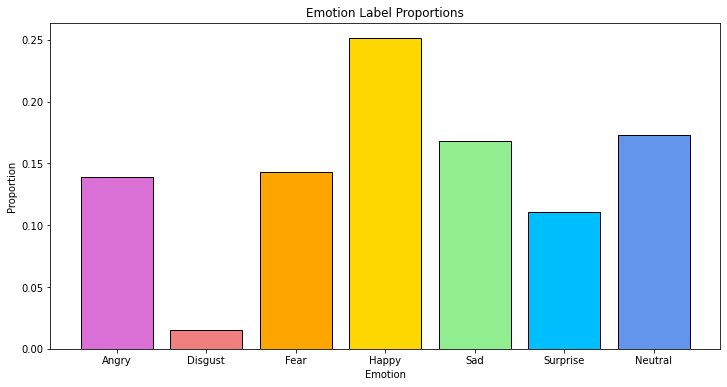

In [16]:
palette = ['orchid', 'lightcoral', 'orange', 'gold', 'lightgreen', 'deepskyblue', 'cornflowerblue']

plt.figure(figsize=[12,6])

plt.bar(x=emotions, height=emotion_prop['emotion'], color=palette, edgecolor='black')
    
plt.xlabel('Emotion')
plt.ylabel('Proportion')
plt.title('Emotion Label Proportions')
plt.show()

As we can see from the distribution of labels, there is a class imbalance within this training set: the emotion happy accounts for about 25% of the data.

# View Sample of Image

view a sample of images for each eotions labeled

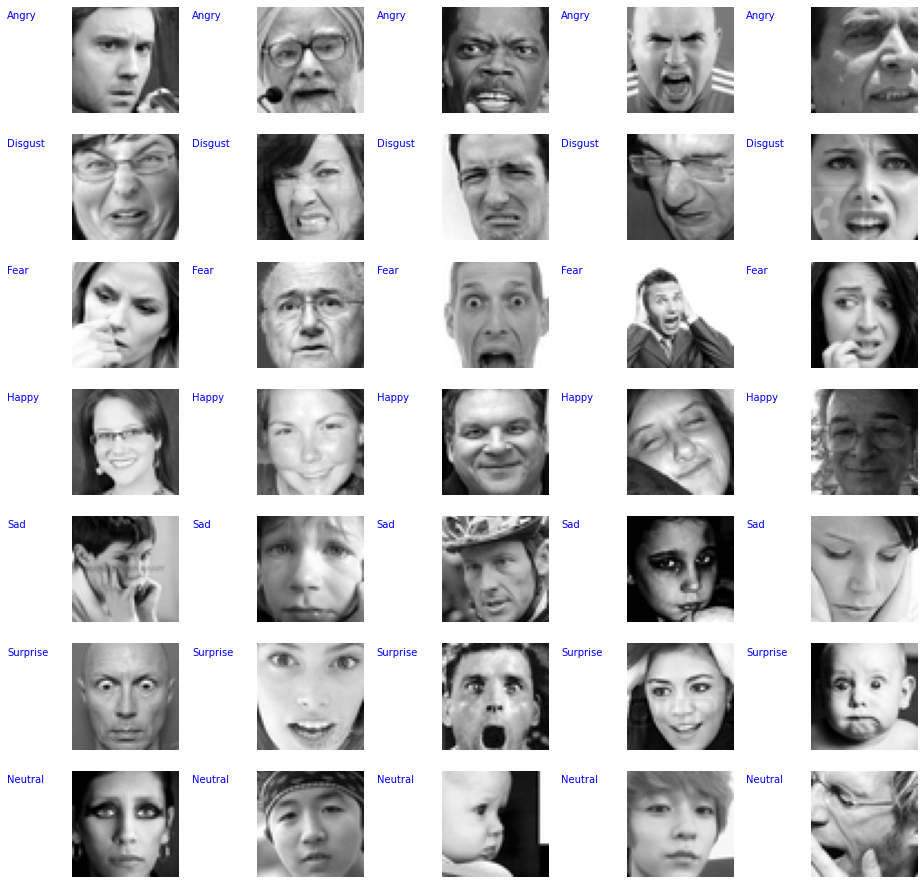

In [17]:
plt.close()
plt.rcParams["figure.figsize"] = [16,16]

row = 0
for emotion in np.unique(labels):

    all_emotion_images = train[train['emotion'] == emotion]
    for i in range(5):
        
        img = all_emotion_images.iloc[i,].pixels.reshape(48,48)
        lab = emotions[emotion]

        plt.subplot(7,5,row+i+1)
        plt.imshow(img, cmap='binary_r')
        plt.text(-30, 5, s = str(lab), fontsize=10, color='b')
        plt.axis('off')
    row += 5

plt.show()

# Split, Reshape, ScaleDatasets

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(
    pixels, labels, test_size=0.2, stratify=labels, random_state=1
)


print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print()
print('X_valid Shape:', X_valid.shape)
print('y_valid Shape:', y_valid.shape)

X_train Shape: (22967, 48, 48)
y_train Shape: (22967,)

X_valid Shape: (5742, 48, 48)
y_valid Shape: (5742,)


ResNet50 was trained with RGB images, and our data is in grayscale. In order to use the pretrained weights of the ResNet50 model we need to convert the single grayscale channel of our images into 3 channels (RGB).

In [19]:
rgb_X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
print(rgb_X_train.shape)

rgb_X_valid = np.repeat(X_valid[..., np.newaxis], 3, -1)
print(rgb_X_valid.shape)

(22967, 48, 48, 3)
(5742, 48, 48, 3)


# Image Augmentation

to prevent overlifting, we use image augmentation to create additional training observations

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range = 5,
    width_shift_range = 0.3, 
    height_shift_range = 0.3,
    shear_range=0.3, 
    # zoom_range = 0.3, 
    horizontal_flip = True, 
    vertical_flip=True,
    fill_mode = 'nearest'
)

train_loader = train_datagen.flow(rgb_X_train, y_train, batch_size=64)

Transfer learning with ResNet50 model

In [22]:
resnet_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_shape=(48,48,3))

# resnet_model.trainable = False
# Freezing Layers

for layer in resnet_model.layers[:-4]:
    layer.trainable=False

94781440/94765736 [==============================] - 1s 0us/step


In [23]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

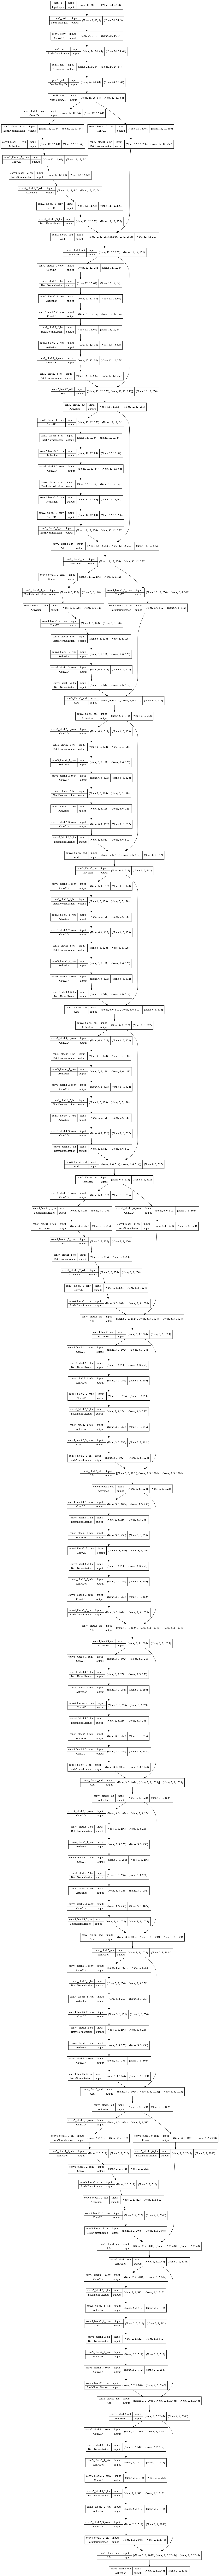

In [24]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)

# Configure Model

add density-connected layers, incoporating dropout and batch normalization

In [25]:
np.random.seed(1)
tf.random.set_seed(1)

#Sequential model allows to build a model layer by layer
#activation function : relu
#input_shape : shape of image matrix : 48x48x3 : (RGB Image)

cnn = Sequential([
#--------------------------------Input layer------------------------------------------# 
    resnet_model,
#Batch Normalization : It is used to normalize the output of the previous layers. The activations scale the input layer in normalization.
#Using batch normalization learning becomes efficient also it can be used as regularization to avoid overfitting of the model.  
    BatchNormalization(),

#converts 3d vector to 1 d vector : Flatten serves as a connection between the convolution and dense layers.
    Flatten(),

#--------------------------------Output layers------------------------------------------#    
#‘Dense’ is the layer type we will use in for our output layer. 

    Dense(512, activation='relu'), #Dense layer predict labels
    BatchNormalization(),
    Dropout(0.7),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
#Softmax makes the output sum up to 1 so the output can be interpreted as probabilities.
    Dense(7, activation='softmax')
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 2048)       8192      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 512)               0

In [26]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      
]

# Train Model

In [27]:
#Parameters:
#1) The optimizer controls the learning rate. Optmizerused : 'adam'. The adam optimizer adjusts the learning rate throughout training.
#2) Loss function used: ‘categorical_crossentropy". A lower score indicates that the model is performing better.
#3) To make things even easier to interpret, ‘accuracy’ metric is used to see the accuracy score on the validation set when we train the model.

opt = tf.keras.optimizers.Adam(0.0001)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 30

Lets pass a callback on to the odel so it saves modelweights

In [28]:
%%time 
#The batch size defines the number of samples that will be propagated through the network.(at a time)
h1 = cnn.fit(
    train_loader, 
    batch_size=32,
    epochs = 30,
    verbose = 1,
    callbacks=[lrd,mcp,es],
    validation_data = (rgb_X_valid, y_valid)
)

Epoch 1/30
359/359 [==============================] - 302s 828ms/step - loss: 2.8898 - accuracy: 0.1631 - val_loss: 1.8361 - val_accuracy: 0.3116 - lr: 1.0000e-04
Epoch 2/30
359/359 [==============================] - 295s 821ms/step - loss: 2.5582 - accuracy: 0.1967 - val_loss: 1.7609 - val_accuracy: 0.3365 - lr: 1.0000e-04
Epoch 3/30
359/359 [==============================] - 294s 818ms/step - loss: 2.3868 - accuracy: 0.2110 - val_loss: 1.7498 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 4/30
359/359 [==============================] - 295s 822ms/step - loss: 2.2639 - accuracy: 0.2249 - val_loss: 1.7190 - val_accuracy: 0.3363 - lr: 1.0000e-04
Epoch 5/30
359/359 [==============================] - 294s 819ms/step - loss: 2.1717 - accuracy: 0.2356 - val_loss: 1.7051 - val_accuracy: 0.3420 - lr: 1.0000e-04
Epoch 6/30
359/359 [==============================] - 295s 819ms/step - loss: 2.0850 - accuracy: 0.2435 - val_loss: 1.6849 - val_accuracy: 0.3494 - lr: 1.0000e-04
Epoch 7/30
359/359 [==

In [29]:
#save model
cnn.save("my_model2.hdf5")

In [ ]:
cnn.save_weights("my-weights")

In [30]:
history = h1.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [ ]:
print(history)

{'loss': [2.3660717010498047, 2.148904323577881, 2.0325615406036377, 1.9625905752182007, 1.9090431928634644, 1.8782944679260254, 1.8611122369766235, 1.8317694664001465, 1.8194719552993774, 1.8130935430526733, 1.799185872077942, 1.7808736562728882, 1.776497483253479, 1.767473578453064, 1.7703529596328735, 1.7658756971359253, 1.75645112991333, 1.7505706548690796, 1.7509924173355103, 1.7459090948104858, 1.7438462972640991, 1.737394094467163, 1.7388014793395996, 1.730985403060913, 1.7323873043060303, 1.7261487245559692, 1.724432349205017, 1.719613790512085, 1.7217025756835938, 1.7220882177352905, 1.7224042415618896, 1.716219186782837, 1.7152143716812134, 1.7120503187179565, 1.7150154113769531, 1.7088426351547241, 1.7121657133102417, 1.7066956758499146, 1.7058510780334473, 1.7059075832366943, 1.7016793489456177, 1.7071316242218018, 1.7004597187042236, 1.701106309890747, 1.7005188465118408, 1.7007532119750977, 1.6992546319961548, 1.6984611749649048, 1.6900873184204102, 1.6953779458999634, 1.

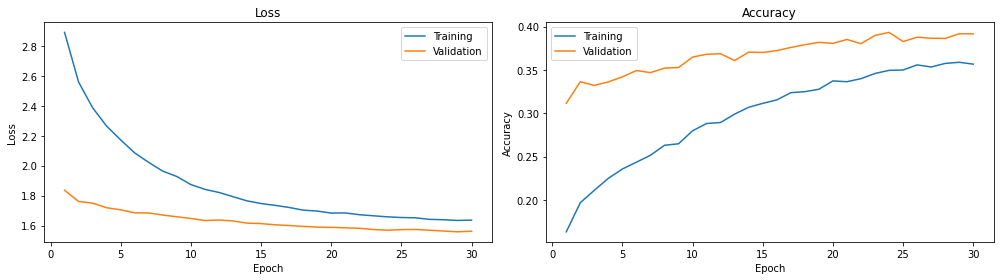

In [31]:
epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

From the learning curves we can see there is slight overfitting, and the model could benefit from additional epochs.

Fine tune modal

In [71]:
y_valid.shape

(5742,)

In [78]:
# test_true = np.argmax(y_valid, axis=0)
test_pred = np.argmax(cnn.predict(rgb_X_valid), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(y_valid, test_pred)))

CNN Model Accuracy on test set: 0.3917


In [62]:
test_true

2

In [72]:
test_pred.shape

(7,)

In [53]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

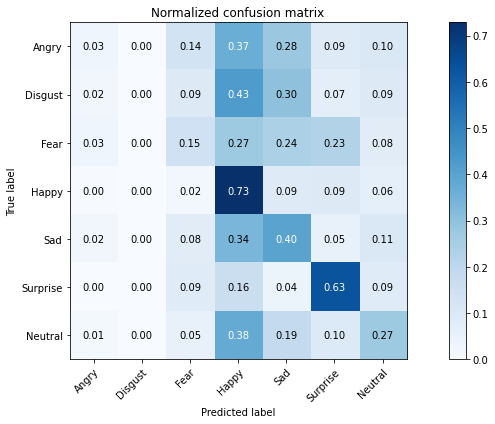

In [80]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_valid, test_pred, classes=emotions, normalize=True, title='Normalized confusion matrix')
plt.show()